# Table of Contents
1. Google Drive Setup
2. Packages and Functions
3. Loading Data and EDA
4. Data Augmentation
5. CNN with unbalanced data
6. Balancing Classes
7. CNN with balanced data
8. AlexNet Structural Model
9. Visualizations

# Google Drive Setup

In [ ]:
#import to reach my google drive holding data
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pwd

'/content'

In [ ]:
#get to the directory with the data
os.chdir('./drive/My Drive/Flatiron/Final Project/')

In [ ]:
#unzip file for the first time
# !unzip -qq data.zip

In [ ]:
pwd #be in final project dir

'/content/drive/My Drive/Flatiron/Final Project'

# Packages and Functions

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
import numpy as np
import itertools

import keras
from keras import models
from keras.models import Sequential, load_model
from keras import layers
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import matplotlib.pyplot as plt
%matplotlib inline

import pickle
random_seed = 123

Using TensorFlow backend.


In [ ]:
def check_data(images,labels):  
    '''
    Checking number of total images and labels to make sure they are the same
    Print the number of class images for jindo and shiba (class imbalance)
    Print the plots of 9 images
    '''
    #find all indexes with a value of 0 and use the first value of the returned tuple
    #taking the length gives the number of indexes with value 0
    num_jindo = len(np.where(labels == 0)[0]) 
    num_shiba = len(np.where(labels == 1)[0])
    
    diff = abs(num_jindo-num_shiba)
    
    print('Number of images: {} and labels: {}'.format(len(images), len(labels)))
    print('Number of Jindo images: {}, Number of Shiba images: {}'.format(num_jindo,num_shiba))
    if num_jindo != num_shiba:
        print('Class is imbalanced by: {}'.format(diff))
    
    #plot with matplotlib    
    for i in range(9):
        plt.subplot(330 + 1 + i)
        plt.imshow((images[i]*225).astype(np.uint8)) #cast to avoid clipping data error
        plt.axis('off') #Turn axes on or off
    plt.show()

In [ ]:
def pickle_save(model,name):
    '''
    saving models with pickle
    '''
    full_name = name + '.pickle'
    with open(full_name, 'wb') as f:
        pickle.dump(model, f)

# Loading data and EDA

In [ ]:
# get all the data in the directory split/test, and reshape them
data_all = ImageDataGenerator(rescale = 1./225).flow_from_directory( 
        './data', 
        target_size=(224, 224), 
        batch_size = 532,
        classes = ['jindo','shiba'],
        class_mode = 'binary',
         seed = random_seed
) 

images, labels = next(data_all)

Found 532 images belonging to 2 classes.


Number of images: 532 and labels: 532
Number of Jindo images: 245, Number of Shiba images: 287
Class is imbalanced by: 42


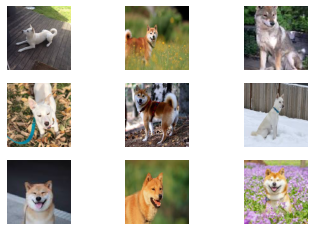

In [ ]:
plt.axis('off')
check_data(images,labels)

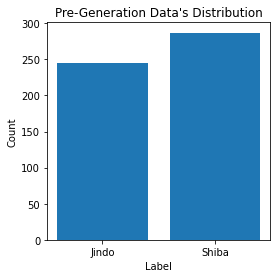

In [ ]:
fig, ax = plt.subplots(figsize = (4,4))

#find all indexes with a value of 0 and use the first value of the returned tuple
#taking the length gives the number of indexes with value 0
num_jindo = len(np.where(labels == 0)[0]) 
num_shiba = len(np.where(labels == 1)[0])

ax.bar(['Jindo','Shiba'],[num_jindo,num_shiba])
plt.title('Pre-Generation Data\'s Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

# plt.savefig('pre_gen_distribution.png', transparent= True)
plt.show()

# Data Augmentation
Since I have only 250 and 300 images of each class (the typical amount of data needed for CNNs are usually 1,000 per class) I decided to use offline augmentation to make my dataset bigger.
The first 3 generations are on both classes and the last is to address the class imbalance.

#### 3 Image generators on both classes

In [ ]:
img_gen1 = ImageDataGenerator(rescale=1./255, 
                             rotation_range=-20,
                             horizontal_flip=True,
                             fill_mode= 'reflect')

data_generatation_1 = img_gen1.flow_from_directory( 
        './data', 
        target_size=(224, 224), 
        batch_size = 532,
        classes = ['jindo','shiba'], 
        class_mode = 'binary',
        seed = random_seed
) 

images_gen1, labels_gen1 = next(data_generatation_1)

Found 532 images belonging to 2 classes.


In [ ]:
img_gen2 = ImageDataGenerator(rescale=1./255, 
                             rotation_range=-20,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode= 'reflect')

data_generatation_2 = img_gen2.flow_from_directory( 
        './data', 
        target_size=(224, 224), 
        batch_size = 532,
        classes = ['jindo','shiba'],
        class_mode = 'binary',
        seed = random_seed
) 
images_gen2, labels_gen2 = next(data_generatation_2)

Found 532 images belonging to 2 classes.


In [ ]:
img_gen3 = ImageDataGenerator(rescale=1./255, 
                             rotation_range=40,
                             width_shift_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode= 'reflect')

data_generation_3 = img_gen3.flow_from_directory( 
        './data', 
        target_size=(224, 224), 
        batch_size = 532,
        classes = ['jindo','shiba'],
        class_mode = 'binary',
        seed = random_seed
)

images_gen3, labels_gen3 = next(data_generation_3)

Found 532 images belonging to 2 classes.


In [ ]:
#combine results of the generation
images = np.concatenate([images,images_gen1,images_gen2,images_gen3])
labels = np.concatenate([labels,labels_gen1,labels_gen2,labels_gen3])

Number of images: 2128 and labels: 2128
Number of Jindo images: 980, Number of Shiba images: 1148
Class is imbalanced by: 168


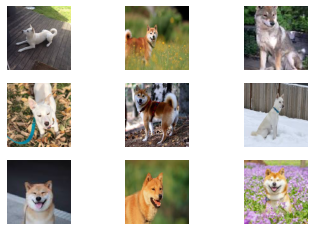

In [ ]:
check_data(images,labels)

# Train Test Split

In [ ]:
#split data into model set and test set
# X_model, X_test, y_model, y_test = train_test_split(balanced_images, balanced_labels, test_size=0.20, random_state=123)
X_model, X_test, y_model, y_test = train_test_split(images, labels, test_size=0.20, random_state=123)

#split model set into train and testing
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.20, random_state=123)
X_train.shape, X_test.shape

((340, 224, 224, 3), (107, 224, 224, 3))

---

# CNN with unbalanced data:

In [ ]:
cnn = models.Sequential()

#feature learning
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3)))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

#classification
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])

<b>Thoughts </b>

Having a model with too small of batches lead to overfitting because of the low number of data points (usually need 1,000 for each class) as well as low batch size. This is because the model finds out the best way to minimize the loss function is by just purely guessing one class. This is why data augmentation is neccessary

<b> Baseline CNN Model </b>


In [ ]:
cnn = models.Sequential()

#feature learning
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3)))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

#classification
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])

In [ ]:
cnn_model = cnn.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=150,
                    validation_data=(X_val, y_val))

Train on 1361 samples, validate on 341 samples
Epoch 1/5
1361/1361 [==============================] - 4s 3ms/step - loss: 1.0503 - acc: 0.5129 - val_loss: 0.6915 - val_acc: 0.5191
Epoch 2/5
1361/1361 [==============================] - 4s 3ms/step - loss: 0.6808 - acc: 0.5364 - val_loss: 0.6685 - val_acc: 0.5630
Epoch 3/5
1361/1361 [==============================] - 4s 3ms/step - loss: 0.6376 - acc: 0.6576 - val_loss: 0.6118 - val_acc: 0.7185
Epoch 4/5
1361/1361 [==============================] - 4s 3ms/step - loss: 0.5950 - acc: 0.6965 - val_loss: 0.6512 - val_acc: 0.6158
Epoch 5/5
1361/1361 [==============================] - 4s 3ms/step - loss: 0.5379 - acc: 0.7311 - val_loss: 0.5955 - val_acc: 0.7331


In [ ]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
print(results_train, results_test)

predictions = cnn.predict(X_test)
predictions = np.around(predictions)

confusion_matrix(y_test, predictions)

#[0.3654047561033433, 0.8530492186546326] [0.5881827963349965, 0.7112675905227661]

426/426 [==============================] - 1s 1ms/step
[0.4741762176232685, 0.7891256213188171] [0.5458451932025068, 0.7183098793029785]


array([[106,  78],
       [ 42, 200]])

In [ ]:
pickle_save(cnn,'baseline')

With this baseline model, I need to address the issues of overfitting by actually using balanced classes from the 4th data augmentation, and dropout regularization as a layer in the neural net


---

# Class Balancing
Note: Rather than class balancing, there may be an option to use 3 augmentations and weights or try smote again

In [ ]:
#final image generation for balancing classes. Current best unbalanced model is cnn3
img_gen4 = ImageDataGenerator(rescale=1./255, 
                             rotation_range=30,
#                              width_shift_range=0.2,
#                              height_shift_range=0.2,
#                              shear_range=0.2,
#                              zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode= 'reflect')

data_generation_4 = img_gen4.flow_from_directory( 
        './data/', 
        target_size=(224, 224), 
        batch_size = 168,  #class differences
        classes = ['jindo'],
        class_mode = 'binary',
        seed = random_seed
)

images_gen4, labels_gen4 = next(data_generation_4)

Found 245 images belonging to 1 classes.


Number of images: 168 and labels: 168
Number of Jindo images: 168, Number of Shiba images: 0
Class is imbalanced by: 168


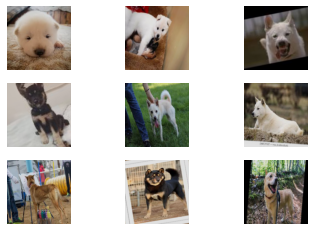

In [ ]:
#check to make sure we generated the right amount of data.
check_data(images_gen4,labels_gen4)

In [ ]:
#Add the jindo generated data to prior data 
final_images = np.concatenate([images,images_gen4])
final_labels = np.concatenate([labels,labels_gen4])

In [ ]:
num_jindo = len(np.where(final_labels == 0)[0]) 
num_shiba = len(np.where(final_labels == 1)[0])

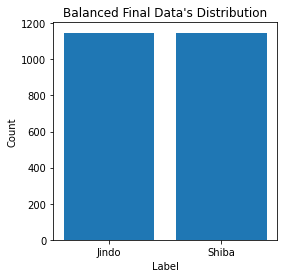

In [ ]:
#plot
fig, ax = plt.subplots(figsize = (4,4))

ax.bar(['Jindo','Shiba'],[num_jindo,num_shiba])

plt.title('Balanced Final Data\'s Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

plt.savefig('post_gen_distribution.png',transparent = True)
plt.show()

In [ ]:
#split data into model set and test set
X_model, X_test, y_model, y_test = train_test_split(final_images, final_labels, test_size=0.20, random_state=123)

#split model set into train and testing
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.20, random_state=123)
X_train.shape, X_test.shape

---

# CNN with balanced classes
In addition to balance classes, I also use dropout regularization and tested a combination of this and batch normalization, but found just using dropout regularization was best

In [ ]:
cnn_withdrop = models.Sequential()

#feature learning
cnn_withdrop.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3)))
cnn_withdrop.add(layers.MaxPooling2D((2, 2)))
cnn_withdrop.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_withdrop.add(layers.MaxPooling2D((2, 2)))

cnn_withdrop.add(Dropout(0.3, input_shape=(224,224,3)))

# cnn_withdrop.add(BatchNormalization())

#classification
cnn_withdrop.add(layers.Flatten())
cnn_withdrop.add(layers.Dense(32, activation='relu'))

cnn_withdrop.add(Dropout(0.3, input_shape=(224,224,3)))

cnn_withdrop.add(layers.Dense(1, activation='sigmoid'))

cnn_withdrop.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])

In [ ]:
cnn_dropout = cnn_withdrop.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=260,
                    validation_data=(X_val, y_val))

Train on 1468 samples, validate on 368 samples
Epoch 1/5
1468/1468 [==============================] - 3s 2ms/step - loss: 1.3803 - acc: 0.5095 - val_loss: 0.7034 - val_acc: 0.5000
Epoch 2/5
1468/1468 [==============================] - 2s 1ms/step - loss: 0.6887 - acc: 0.5708 - val_loss: 0.6882 - val_acc: 0.5598
Epoch 3/5
1468/1468 [==============================] - 2s 1ms/step - loss: 0.6569 - acc: 0.6308 - val_loss: 0.6718 - val_acc: 0.6168
Epoch 4/5
1468/1468 [==============================] - 2s 1ms/step - loss: 0.6104 - acc: 0.7112 - val_loss: 0.6218 - val_acc: 0.6766
Epoch 5/5
1468/1468 [==============================] - 2s 1ms/step - loss: 0.5718 - acc: 0.7180 - val_loss: 0.6402 - val_acc: 0.6141


In [ ]:
results_train_dropout = cnn_withdrop.evaluate(X_train, y_train)
results_test_dropout = cnn_withdrop.evaluate(X_test, y_test)
print('Train: ',results_train_dropout[1], ' Test: ',results_test_dropout[1])

predictions_dropout = cnn_withdrop.predict(X_test)
predictions_dropout = np.around(predictions_dropout)

print('F1: ',f1_score(y_test,predictions_dropout))
confusion_matrix(y_test, predictions_dropout)

460/460 [==============================] - 0s 705us/step
Train:  0.7397820353507996  Test:  0.6391304135322571
F1:  0.7035714285714286


array([[ 97, 131],
       [ 35, 197]])

In [ ]:
pickle_save(cnn_withdrop,'cnn_dropout')

#### Iterative Param Search with script

In [ ]:
from keras.layers import Dropout

In [ ]:
def make_model(dropout):
    keras.backend.clear_session()
  cnn_withdrop = models.Sequential()

  #feature learning
  cnn_withdrop.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3)))
  cnn_withdrop.add(layers.MaxPooling2D((2, 2)))
  cnn_withdrop.add(layers.Conv2D(32, (3, 3), activation='relu'))
  cnn_withdrop.add(layers.MaxPooling2D((2, 2)))

  cnn_withdrop.add(Dropout(dropout, input_shape=(224,224,3)))
  # cnn_withdrop.add(BatchNormalization())

  #classification
  cnn_withdrop.add(layers.Flatten())
  cnn_withdrop.add(layers.Dense(32, activation='relu'))

  cnn_withdrop.add(Dropout(0.3, input_shape=(224,224,3)))

  cnn_withdrop.add(layers.Dense(1, activation='sigmoid'))

  cnn_withdrop.compile(loss='binary_crossentropy',
                optimizer="adam",
                metrics=['acc'])
  
  return cnn_withdrop

In [ ]:
dropouts = [0.1,0.2,0.3]
epochs = [5,10,15]
batches = [200,250,300]

params = [dropouts,epochs,batches]

results2 = {}

for params in list(itertools.product(*params)):
      print('Fitting on: ',params )

      #make the model
      cnn = make_model(params[0])
      #fit model on params
      cnn_model = cnn.fit(X_train,
              y_train,
              epochs= params[1],
              batch_size= params[2],
              validation_data=(X_val, y_val))
      
      results_train = cnn.evaluate(X_train, y_train)
      results_test = cnn.evaluate(X_test, y_test)

      predictions = cnn.predict(X_test)
      predictions = np.around(predictions)

      results2[params] = (results_train[1],results_test[1], f1_score(y_test,predictions))

      print('-'*8)

Fitting on:  (0.1, 5, 200)
Train on 1468 samples, validate on 368 samples
Epoch 1/5
1468/1468 [==============================] - 2s 1ms/step - loss: 0.9204 - acc: 0.5007 - val_loss: 0.6900 - val_acc: 0.5027
Epoch 2/5
1468/1468 [==============================] - 2s 1ms/step - loss: 0.6785 - acc: 0.5170 - val_loss: 0.6846 - val_acc: 0.5516
Epoch 3/5
1468/1468 [==============================] - 2s 1ms/step - loss: 0.6757 - acc: 0.5906 - val_loss: 0.6665 - val_acc: 0.6712
Epoch 4/5
1468/1468 [==============================] - 2s 1ms/step - loss: 0.6487 - acc: 0.6635 - val_loss: 0.6468 - val_acc: 0.6495
Epoch 5/5
460/460 [==============================] - 0s 591us/step
Fitting on:  (0.1, 5, 250)
Train on 1468 samples, validate on 368 samples
Epoch 1/5
1468/1468 [==============================] - 4s 2ms/step - loss: 1.0431 - acc: 0.5102 - val_loss: 0.6922 - val_acc: 0.5408
Epoch 2/5
1468/1468 [==============================] - 2s 1ms/step - loss: 0.6900 - acc: 0.5150 - val_loss: 0.6831 - val

In [ ]:
results #best params are (0.3,5,250) with results of (0.734, 0.721, 0.709090)

{(0.1, 5, 200): (0.7016348838806152, 0.6282608509063721, 0.7076923076923077),
 (0.1, 5, 250): (0.7179836630821228, 0.667391300201416, 0.7171903881700554),
 (0.1, 5, 300): (0.7513623833656311, 0.7217391133308411, 0.7276595744680852),
 (0.1, 10, 200): (0.8719345927238464, 0.708695650100708, 0.7161016949152542),
 (0.1, 10, 250): (0.7983651161193848, 0.647826075553894, 0.55),
 (0.1, 10, 300): (0.7908719182014465, 0.6847826242446899, 0.7094188376753507),
 (0.1, 15, 200): (0.9550408720970154, 0.7043478488922119, 0.7235772357723578),
 (0.1, 15, 250): (0.8276566863059998, 0.6913043260574341, 0.7029288702928871),
 (0.1, 15, 300): (0.9400544762611389, 0.678260862827301, 0.7004048582995952),
 (0.2, 5, 200): (0.5211171507835388, 0.5130434632301331, 0.672514619883041),
 (0.2, 5, 250): (0.7023161053657532, 0.654347836971283, 0.708256880733945),
 (0.2, 5, 300): (0.5817438960075378, 0.5456521511077881, 0.23443223443223443),
 (0.2, 10, 200): (0.502043604850769, 0.4956521689891815, 0.0),
 (0.2, 10, 250)

In [ ]:
make_model(0.3).fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=250,
                    validation_data=(X_val, y_val))

Train on 1468 samples, validate on 368 samples
Epoch 1/50
1468/1468 [==============================] - 2s 1ms/step - loss: 1.5395 - acc: 0.5014 - val_loss: 0.6942 - val_acc: 0.4973
Epoch 2/50
1468/1468 [==============================] - 2s 1ms/step - loss: 0.6942 - acc: 0.5075 - val_loss: 0.6926 - val_acc: 0.5027
Epoch 3/50
1468/1468 [==============================] - 2s 1ms/step - loss: 0.6900 - acc: 0.5238 - val_loss: 0.6873 - val_acc: 0.5054
Epoch 4/50
1468/1468 [==============================] - 2s 1ms/step - loss: 0.6752 - acc: 0.5817 - val_loss: 0.6511 - val_acc: 0.6522
Epoch 5/50
1468/1468 [==============================] - 2s 1ms/step - loss: 0.6469 - acc: 0.6417 - val_loss: 0.6510 - val_acc: 0.6332
Epoch 6/50
1468/1468 [==============================] - 2s 1ms/step - loss: 0.6179 - acc: 0.6975 - val_loss: 0.6097 - val_acc: 0.6630
Epoch 7/50
1468/1468 [==============================] - 2s 1ms/step - loss: 0.6152 - acc: 0.6805 - val_loss: 0.6419 - val_acc: 0.6196
Epoch 8/50
1468

---

# AlexNet Structural Model (CNN)

## AlexNet Preprocess
Attempted to use the AlexNet structure to try to use a low amount of data. The code in this section has getting the data and balancing with only a singular data augmentation. Ultimately after doing this, the model still wasn't sufficient in predicting probably because of the lack of data again.

In [ ]:
# get all the data in the directory split/test, and reshape them
data_all = ImageDataGenerator(rescale = 1./225).flow_from_directory( 
        './data', 
        target_size=(224, 224),  #using 227 is best with an AlexNet, but is a feature step as it requires adjusting layers
        batch_size = 532,
        classes = ['jindo','shiba'],
        class_mode = 'binary',
         seed = random_seed
) 

images, labels = next(data_all)

Found 532 images belonging to 2 classes.


In [ ]:
# Double check class balance
num_jindo = len(np.where(labels == 0)[0]) 
num_shiba = len(np.where(labels == 1)[0])
diff = abs(num_jindo - num_shiba)
num_jindo, num_shiba , diff

(245, 287, 42)

In [ ]:
#create images from JINDO only for balancing dataset. Current best unbalanced model is cnn3
img_gen_jindo = ImageDataGenerator(rescale=1./255, 
                             rotation_range=30,
                             horizontal_flip=True,
                             fill_mode= 'reflect')

data_generation_jindo = img_gen_jindo.flow_from_directory( 
        './data/', 
        target_size=(224, 224), 
        batch_size = diff,  #class differences 
        classes = ['jindo'],
        class_mode = 'binary',
        seed = random_seed
)

images_gen_jindo, labels_gen_jindo = next(data_generation_jindo)
#expect 245 images

Found 245 images belonging to 1 classes.


Number of images: 42 and labels: 42
Number of Jindo images: 42, Number of Shiba images: 0
Class is imbalanced by: 42


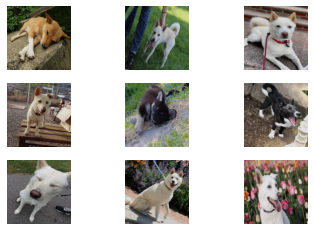

In [ ]:
plt.axis('off')
check_data(images_gen_jindo,labels_gen_jindo)

In [ ]:
balanced_images = np.concatenate([images,images_gen_jindo])
balanced_labels = np.concatenate([labels,labels_gen_jindo])

## Model
Modeling using final_images train split which has augmented data.

In [ ]:
#split data into model set and test set

#Note: the x,y params are from a final augmented balanced data set
X_model, X_test, y_model, y_test = train_test_split(final_images, final_labels, test_size=0.20, random_state=123)

#split model set into train and testing
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.20, random_state=123)
X_train.shape, X_test.shape

In [ ]:
def make_alex():
  '''
  Make a model with the same structure as an AlexNet. The structural alexnet code is from https://engmrk.com/alexnet-implementation-using-keras/, and
  changes of dropout regularization perecent and learning rate have been adjusted for my model
  '''
  #clear an existing models
  keras.backend.clear_session()

  #Instantiate an empty model
  model = Sequential()

  # 1st Convolutional Layer
  model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
  model.add(Activation('relu'))
  # Max Pooling
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

  # 2nd Convolutional Layer
  model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
  model.add(Activation('relu'))
  # Max Pooling
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

  # 3rd Convolutional Layer
  model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
  model.add(Activation('relu'))

  # 4th Convolutional Layer
  model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
  model.add(Activation('relu'))

  # 5th Convolutional Layer
  model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
  model.add(Activation('relu'))
  # Max Pooling
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

  # Passing it to a Fully Connected layer
  model.add(Flatten())
  # 1st Fully Connected Layer
  model.add(Dense(4096, input_shape=(224*224*3,)))
  model.add(Activation('relu'))
  # Add Dropout to prevent overfitting
  model.add(Dropout(0.1))

  # 2nd Fully Connected Layer
  model.add(Dense(4096))
  model.add(Activation('relu'))
  # Add Dropout
  model.add(Dropout(0.1))

  # 3rd Fully Connected Layer
  model.add(Dense(1000))
  model.add(Activation('relu'))
  # Add Dropout
  model.add(Dropout(0.1))

  # Output Layer
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  # model.summary() #Print the summary if needed

  #Step own optimizer's learning rate
  optimizer = keras.optimizers.Adam(lr=0.0001)

  # Compile the model
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"]) 
  
  return model

In [ ]:
model2 = make_alex()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_2 (Activation)    (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 384)        

In [ ]:
 cnn = model1.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=260,
                    shuffle = False,
                    validation_data=(X_val, y_val))

Train on 1468 samples, validate on 368 samples
Epoch 1/10
1468/1468 [==============================] - 3s 2ms/step - loss: 0.6942 - accuracy: 0.5027 - val_loss: 0.6949 - val_accuracy: 0.4783
Epoch 2/10
1468/1468 [==============================] - 3s 2ms/step - loss: 0.6931 - accuracy: 0.5095 - val_loss: 0.6910 - val_accuracy: 0.4783
Epoch 3/10
1468/1468 [==============================] - 3s 2ms/step - loss: 0.6878 - accuracy: 0.5109 - val_loss: 0.6801 - val_accuracy: 0.5652
Epoch 4/10
1468/1468 [==============================] - 3s 2ms/step - loss: 0.6775 - accuracy: 0.5777 - val_loss: 0.6639 - val_accuracy: 0.6141
Epoch 5/10
1468/1468 [==============================] - 3s 2ms/step - loss: 0.6689 - accuracy: 0.6008 - val_loss: 0.6721 - val_accuracy: 0.5788
Epoch 6/10
1468/1468 [==============================] - 3s 2ms/step - loss: 0.6603 - accuracy: 0.6144 - val_loss: 0.6352 - val_accuracy: 0.6630
Epoch 7/10
1468/1468 [==============================] - 3s 2ms/step - loss: 0.6249 - accu

In [ ]:
results_train = model2.evaluate(X_train, y_train)
results_test = model2.evaluate(X_test, y_test)
print('Train: ',results_train[1], ' Test: ',results_test[1])

predictions = model2.predict(X_test)
predictions = np.around(predictions)

print('F1: ',f1_score(y_test,predictions))
confusion_matrix(y_test, predictions)

460/460 [==============================] - 0s 945us/step
Train:  0.7425068020820618  Test:  0.758695662021637
F1:  0.7494356659142212


array([[183,  53],
       [ 58, 166]])

In [ ]:
pickle_save(model2,'base_model')

##Visualizing wrong labels

In [ ]:
def plot_predictions(misclassified,name): 
  '''
  Given a tuple of image array data, true, and pred labels return the plot of the first 9 images with their respective labels
  '''

  save_name = '{}.png'.format(name
                              )
  for i in range(9):
        plt.figure(1 , figsize = (8,8))
        plt.subplots_adjust(hspace = 0.5, wspace = 0.01)

        img_array = misclassified[i][0]
        true_label = 'Shiba' if misclassified[i][1] == 1 else 'Jindo'
        pred_label = 'Shiba' if float(misclassified[i][2]) == 1 else 'Jindo'

        plt.subplot(330 + 1 + i)
        plt.imshow((img_array*225).astype(np.uint8)) #cast to avoid clipping data error
        plt.title(' True labels: {} \n Pred Label: {}'.format(true_label, pred_label))
        plt.axis('off') #Turn axes on or off

        plt.savefig(save_name, transparent = True, bbox_inches='tight')

  plt.show()

In [ ]:
classified = []
misclassified = []

for x,y,z in zip(X_test, y_test, predictions_dropout):
  if y != z:
    misclassified.append((x,y,z))
  else:
    classified.append((x,y,z))

len(classified),len(misclassified)

(349, 111)

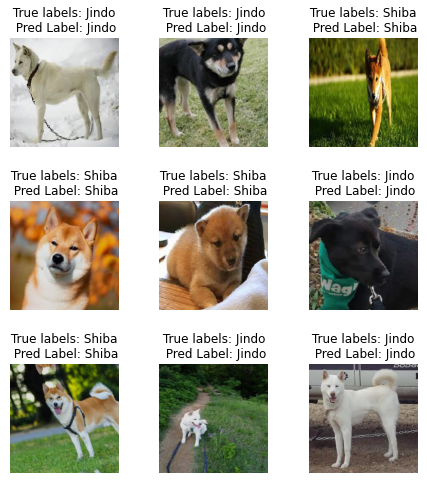

In [ ]:
plot_predictions(classified,'classified')

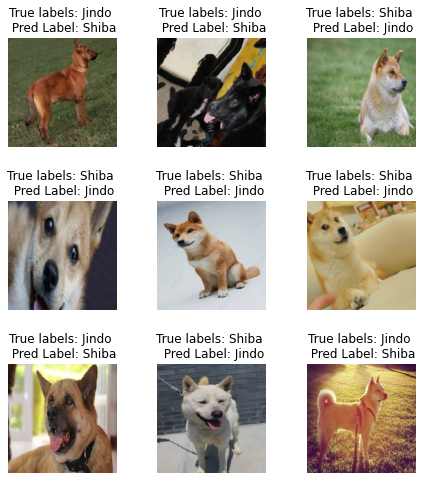

In [ ]:
plot_predictions(misclassified, 'misclassified')

# Visualizations

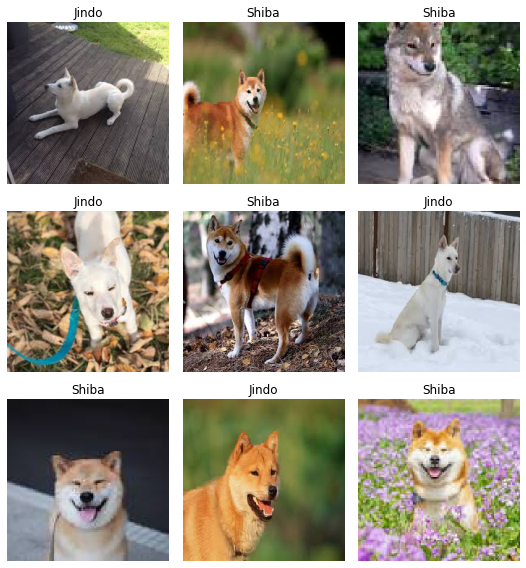

In [ ]:
for i in range(9):
        plt.figure(1 , figsize = (8,8))
        plt.subplot(330 + 1 + i)
        plt.imshow((images[i]*225).astype(np.uint8)) #cast to avoid clipping data error
        plt.axis('off') #Turn axes on or off
        plt.subplots_adjust(hspace = 0.5, wspace = 0.01)
        if labels[i] == 0:
            class_ = 'Jindo'
        else:
            class_ = 'Shiba'
        plt.title(class_)

plt.tight_layout()
# plt.savefig('data_original_collage.png', bbox_inches='tight', transparent = True)        
plt.show()

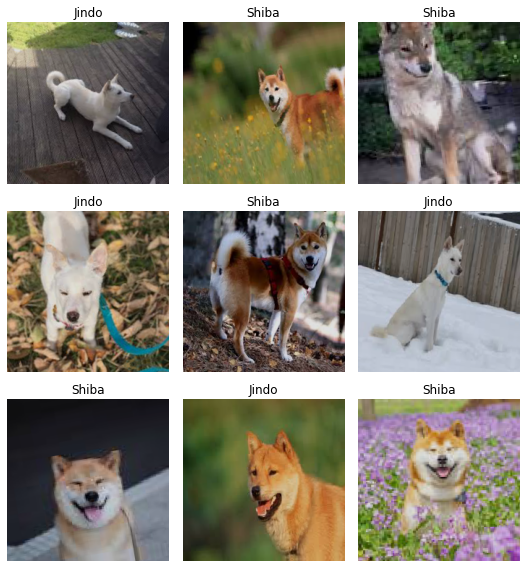

In [ ]:
for i in range(9):
        plt.figure(1 , figsize = (8,8))
        plt.subplot(330 + 1 + i)
        plt.imshow((images_gen1[i]*225).astype(np.uint8)) #cast to avoid clipping data error
        plt.axis('off') #Turn axes on or off
        plt.subplots_adjust(hspace = 0.5, wspace = 0.01)
        if labels_gen1[i] == 0:
            class_ = 'Jindo'
        else:
            class_ = 'Shiba'
        plt.title(class_)

plt.tight_layout()

# plt.savefig('data_augmented.png', bbox_inches='tight', transparent = True)        
plt.show()

In [ ]:
## Trusty ol' resuable matrix graph code
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation = 45)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

[[183  53]
 [ 58 166]]


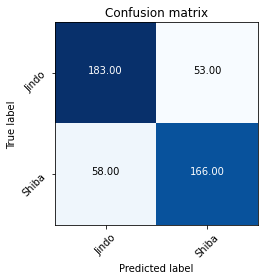

In [ ]:
plot_confusion_matrix(confusion_matrix(y_test,predictions), ['Jindo','Shiba'], normalize = False)
# plt.savefig('confusion_matrix.png', transparent = True)        